I chose a dataset of Bitcoin addresses linked to ransomware attacks because it combines the fields of cryptography and blockchain with cybersecurity, and i think that the cryptography is an interesting subject.
The dataset enables a good analysis of address features and their economic activity, detection of anomalies, building models to identify malicious addresses, and exploring behavioral patterns of ransomware attacks.
Also, since it's based on real cybersecurity research, the analysis feels practical and relevant to real-world scenarios.

System Stage:

File Name: BitcoinHeistData

File Source: The BitcoinHeist Ransomware Address Dataset was published on **Kaggle** by the user "sapere0", based on research by Tai et al.

Link to the data set: https://www.kaggle.com/datasets/sapere0/bitcoinheist-ransomware-dataset

Size: 224MB

Type: CSV

Number Of Lines: We will count it in using pandas later.

* The filename and file extension do not appear to be suspicious.


### Dataset Column Descriptions (BitcoinHeistData.csv)

- **address**: The Bitcoin wallet address that received money. These addresses are usually used by ransomware attackers.

- **year**: The year when the address was last active in the dataset.

- **day**: The day of the year (1 to 365) when the address appeared in the snapshot. Day 1 = Jan 1st, Day 365 = Dec 31st.

- **length**: Represents the number of "mixing rounds", how often coins were sent and received through new addresses.

- **weight**: Measures how much coin merging happened. If many small inputs were combined into one output, the weight will be high.

- **count**: Number of transactions that merged multiple sources of funds.

- **looped**: Number of full coin "loops", when coins were split, sent through different paths, and then merged back into one address. This can be a sign of laundering.

- **neighbors**: Number of other Bitcoin addresses that sent money to or received money from this address. High values suggest the address is part of a wider transaction network.

- **income**: Total amount of money received by the address, in satoshis (1 Bitcoin = 100 million satoshis). This shows how much ransom money was collected.

- **label**: The name of the ransomware family that used this address (`cryptolocker`, `cerber`, ...). If it says `white`, the address is not known to be ransomware.

* I found 1 version on kaggle.

### Meta Data:

In [29]:
import pandas as pd
import os
import re

# Extended phishing bait keywords
phishing_keywords = [
    "phish", "login", "bank", "account", "invoice", "paypal", "secure", "security", "verify", "update", "billing"]

# Regex patterns for leetspeak substitutions
leet_patterns = {
    "a": "[a@]",
    "e": "[e3]",
    "i": "[i1!|]",
    "o": "[o0]",
    "s": "[s5$]",
    "l": "[l1!|]",
    "t": "[t7+]",
    "ph": "(ph|f)",
}

# Function to turn keyword into a regex with leet support
def leetspeak_pattern(word):
    pattern = ""
    i = 0
    while i < len(word):
        # Special case for 'ph'
        if word[i:i+2] == "ph":
            pattern += leet_patterns["ph"]
            i += 2
        else:
            pattern += leet_patterns.get(word[i], word[i])
            i += 1
    return pattern

# Build regex for all phishing keywords
phishing_regexes = [re.compile(leetspeak_pattern(keyword), re.IGNORECASE) for keyword in phishing_keywords]

# Final filename red flag checker
def check_filename_red_flags(filename):
    red_flags = []

    name, ext = os.path.splitext(filename)

    # 1. Multiple extensions (e.g., invoice.pdf.exe)
    if filename.count('.') > 1:
        red_flags.append("Multiple dots (suspicious extensions)")

    # 2. Known phishing bait words with leetspeak
    for regex in phishing_regexes:
        if regex.search(filename):
            red_flags.append("Contains phishing-style name")

    # 3. Random character strings (hash-like)
    if re.fullmatch(r"[a-zA-Z0-9]{8,}", name) and not re.search(r"[aeiou]{2,}", name, re.IGNORECASE):
        red_flags.append("Random character string")

    # 4. Executable disguised as something else
    if filename.lower().endswith((".jpg.exe", ".png.exe", ".pdf.exe", ".docx.exe")):
        red_flags.append("Executable disguised as document or image")

    return red_flags

def check_size_per_row(filepath, min_bytes_per_row=20, max_bytes_per_row=10000):
    file_size = os.path.getsize(filepath)  # in bytes

    try:
        df = pd.read_csv(filepath)
        row_count = len(df)
        if row_count == 0:
            return "Empty file (0 rows)"

        size_per_row = file_size / row_count

        if size_per_row < min_bytes_per_row:
            return f"Too small: {size_per_row:.1f} bytes/row"
        elif size_per_row > max_bytes_per_row:
            return f"Too large: {size_per_row:.1f} bytes/row"
        else:
            return f"OK: {size_per_row:.1f} bytes/row"

    except Exception as e:
        return f"Error reading file: {e}"


# Optional: Show full float precision
pd.set_option('display.float_format', '{:.20f}'.format)

# Set the dataset folder path
folder_path = "Data Set"

# Loop over all CSV files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        print(f"\nProcessing file: {filename}")
        print("=" * 60)

        # Load CSV safely with float parsing
        try:
            df = pd.read_csv(file_path, index_col=False, dtype={'weight': float, 'income': float})
        except Exception as e:
            print(f"Failed to read {filename}: {e}")
            continue

        flags = check_filename_red_flags(filename)
        if flags:
            print(f"\nRed flags in filename: {filename}")
            for flag in flags:
                print(f"  - {flag}")
        else:
            print(f"\nNo name red flags found in filename: {filename}")

        result = check_size_per_row(file_path)
        print(f"File size check result: {result}")
        
        # Check for missing values
        print("\nMissing values per column:")
        print(df.isnull().sum())

        # Check data types
        print("\nData types:")
        print(df.dtypes)

        # Count unique values
        print("\nUnique values per column:")
        for col in df.columns:
            print(f"{col}: {df[col].nunique()} unique values")

        # Look for special values: -999 or 'unknown'
        print("\nChecking for special values (-999 or 'unknown'):")
        mask = (df == -999).any(axis=1) | (df.astype(str) == "unknown").any(axis=1)
        special_values = df[mask].copy()
        special_values["csv_row_number"] = special_values.index + 2

        print(f"Rows with special values: {len(special_values)}")

        # Display them (if any)
        if not special_values.empty:
            cols = ["csv_row_number"] + [col for col in special_values.columns if col != "csv_row_number"]
            special_values = special_values[cols]

            with pd.option_context('display.max_columns', None,
                                   'display.max_colwidth', None,
                                   'display.max_rows', None,
                                   'display.expand_frame_repr', False):
                display(special_values)

        # Check for zero income values
        if "income" in df.columns:
            zero_income = df[df["income"] == 0]
            print(f"\nAddresses with zero income: {len(zero_income)}")

        # Print total row count
        print(f"\nNumber of rows in the CSV file: {len(df)}")
        print("=" * 60)



Processing file: BitcoinHeistData.csv

No name red flags found in filename: BitcoinHeistData.csv
File size check result: OK: 80.9 bytes/row

Missing values per column:
address      0
year         0
day          0
length       0
weight       0
count        0
looped       0
neighbors    0
income       0
label        0
dtype: int64

Data types:
address       object
year           int64
day            int64
length         int64
weight       float64
count          int64
looped         int64
neighbors      int64
income       float64
label         object
dtype: object

Unique values per column:
address: 2631095 unique values
year: 8 unique values
day: 365 unique values
length: 73 unique values
weight: 784927 unique values
count: 11572 unique values
looped: 10168 unique values
neighbors: 814 unique values
income: 1866365 unique values
label: 29 unique values

Checking for special values (-999 or 'unknown'):
Rows with special values: 4


,csv_row_number,address,year,day,length,weight,count,looped,neighbors,income,label
2566168,2566170,unknown,2017,345,144,146.13774144540099086953,5191,4812,1192,662525717815.00000000000000000000,white
2682857,2682859,unknown,2018,97,144,1827.77883521448006831633,4772,4772,7589,3097053880245.00000000000000000000,white
2807623,2807625,unknown,2018,221,144,1866.71672921494996444380,5680,5680,11746,10678161295882.00000000000000000000,white
2879952,2879954,unknown,2018,294,144,1943.74879331340002863726,3975,3975,12920,6510062177369.00000000000000000000,white



Addresses with zero income: 0

Number of rows in the CSV file: 2916697


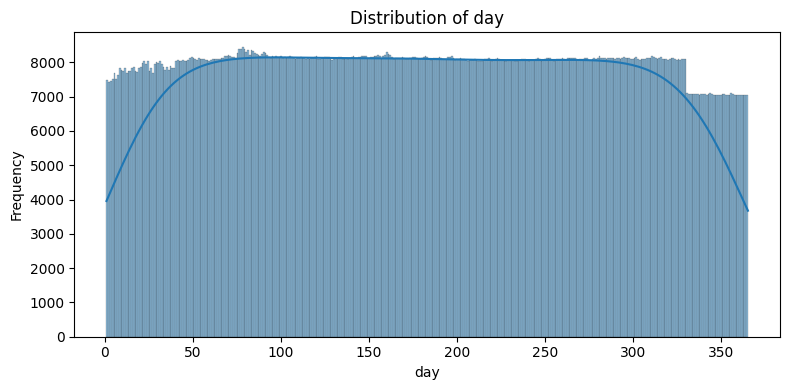

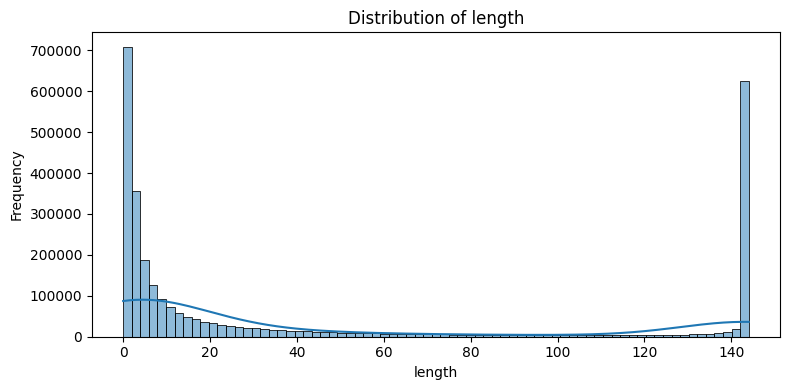

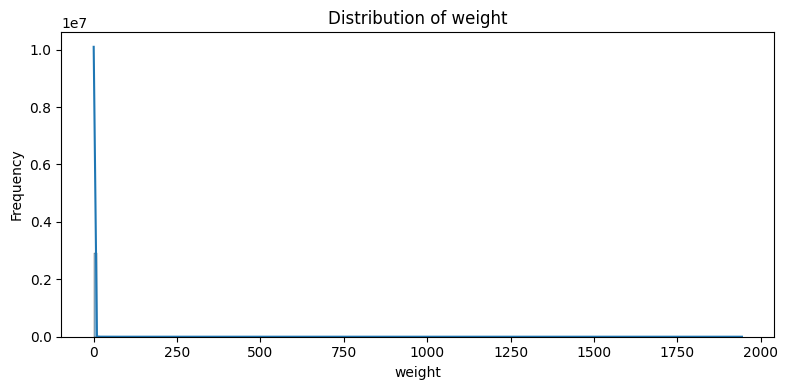

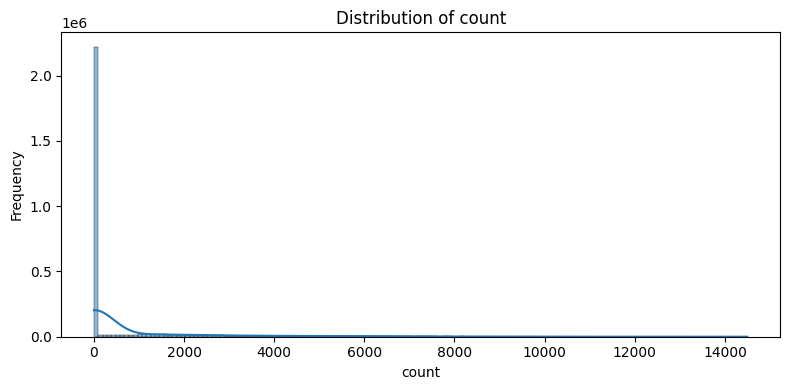

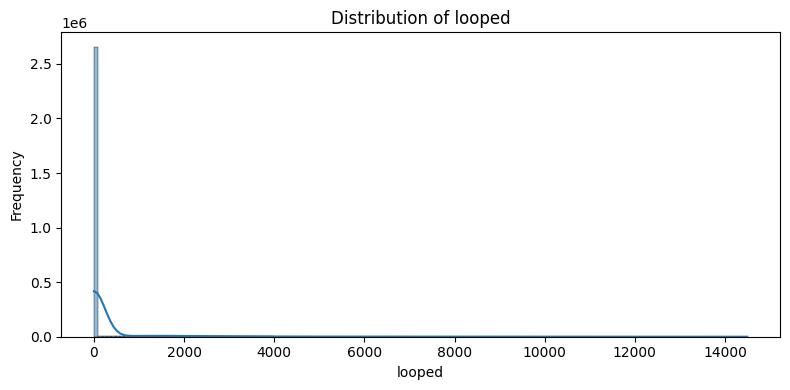

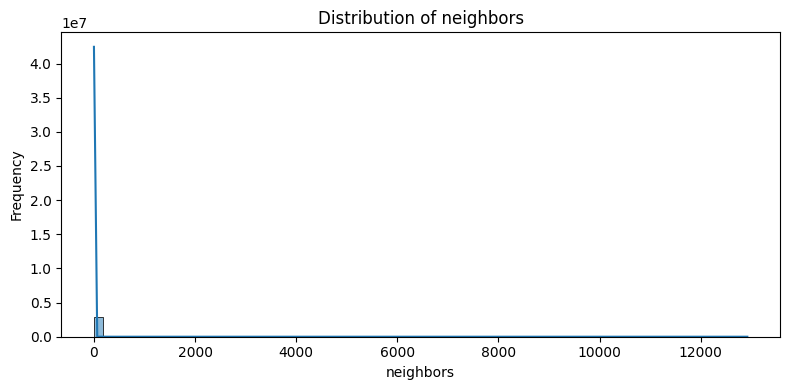

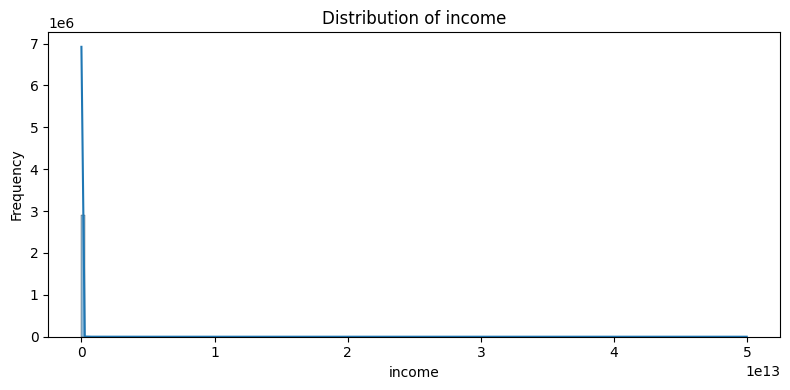

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_histogram(df, column, bins_num=100):
    plt.figure(figsize=(8, 4))
    sns.histplot(df[column], bins=bins_num, kde=True, kde_kws={'bw_adjust': 5.0})
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

plot_histogram(df, 'day', bins_num=365)
plot_histogram(df, 'length', bins_num=73)
plot_histogram(df, 'weight', bins_num=200)
plot_histogram(df, 'count', bins_num=150)
plot_histogram(df, 'looped', bins_num=150)
plot_histogram(df, 'neighbors', bins_num=75)
plot_histogram(df, 'income', bins_num=200)
    

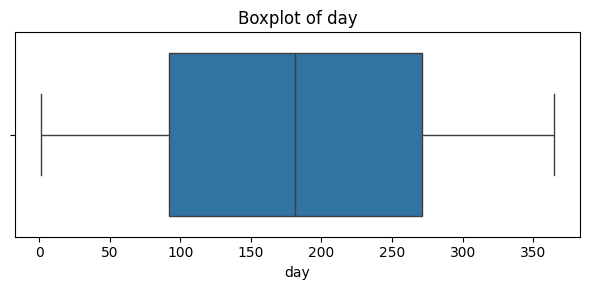


Column: day
Mean: 181.46
Median: 181.00
Std: 104.01
Min: 1.00
Max: 365.00
Skewness: 0.01
Kurtosis: -1.19
Pearson Skewness: 0.01


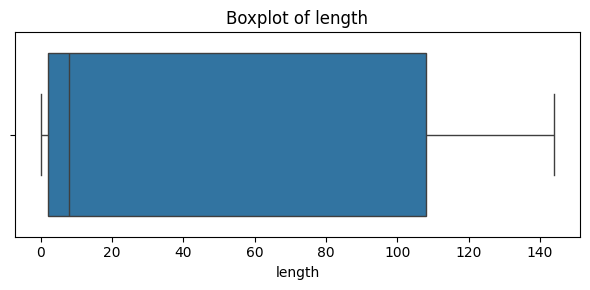


Column: length
Mean: 45.01
Median: 8.00
Std: 58.98
Min: 0.00
Max: 144.00
Skewness: 0.92
Kurtosis: -0.97
Pearson Skewness: 1.88


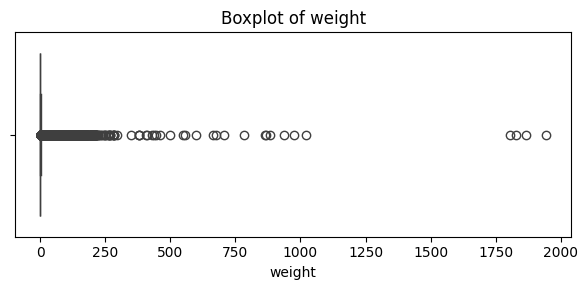


Column: weight
Mean: 0.55
Median: 0.25
Std: 3.67
Min: 0.00
Max: 1943.75
Skewness: 243.02
Kurtosis: 102688.79
Pearson Skewness: 0.24


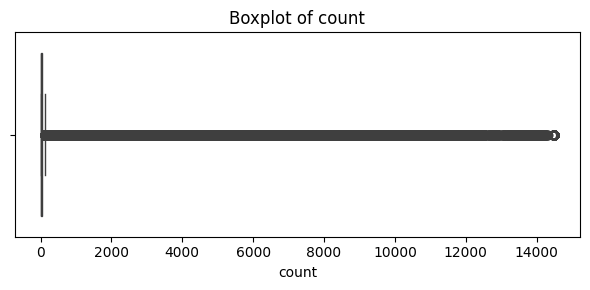


Column: count
Mean: 721.64
Median: 1.00
Std: 1689.68
Min: 1.00
Max: 14497.00
Skewness: 2.93
Kurtosis: 9.42
Pearson Skewness: 1.28


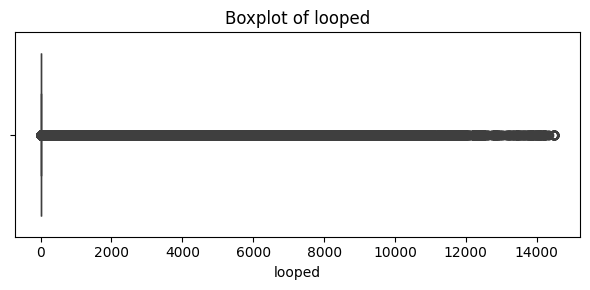


Column: looped
Mean: 238.51
Median: 0.00
Std: 966.32
Min: 0.00
Max: 14496.00
Skewness: 5.52
Kurtosis: 37.24
Pearson Skewness: 0.74


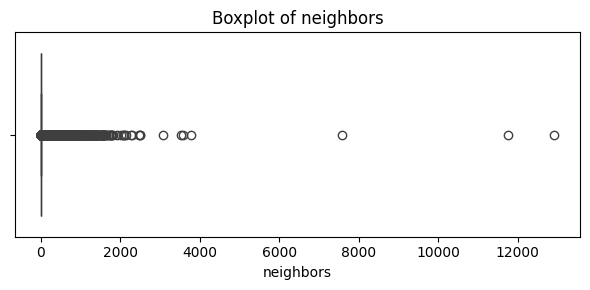


Column: neighbors
Mean: 2.21
Median: 2.00
Std: 17.92
Min: 1.00
Max: 12920.00
Skewness: 293.58
Kurtosis: 171455.60
Pearson Skewness: 0.03


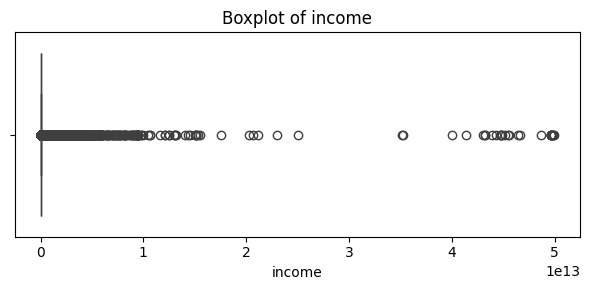


Column: income
Mean: 4464889007.19
Median: 199998518.00
Std: 162685960669.35
Min: 30000000.00
Max: 49964398238996.00
Skewness: 228.37
Kurtosis: 62538.32
Pearson Skewness: 0.08


In [73]:
from scipy.stats import skew, kurtosis

def plot_boxplot(df, column):
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df[column])
    plt.title(f"Boxplot of {column}")
    plt.tight_layout()
    plt.show()


def describe_distribution(df, column):
    data = df[column].dropna()
    print(f"\nColumn: {column}")
    print(f"Mean: {data.mean():.2f}")
    print(f"Median: {data.median():.2f}")
    print(f"Std: {data.std():.2f}")
    print(f"Min: {data.min():.2f}")
    print(f"Max: {data.max():.2f}")
    print(f"Skewness: {skew(data):.2f}")
    print(f"Kurtosis: {kurtosis(data):.2f}")
    pearson_skew = 3 * (data.mean() - data.median()) / data.std()
    print(f"Pearson Skewness: {pearson_skew:.2f}")


numeric_cols = ['day', 'length', 'weight', 'count', 'looped', 'neighbors', 'income']

for col in numeric_cols:
    plot_boxplot(df, col)
    describe_distribution(df, col)